In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.6/749.6 kB 20.5 MB/s eta 0:00:0000:01


In [2]:
import os
import wandb
import shutil
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import warnings
os.mkdir('./datasets')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
IMG_SIZE = 1024
RSNA_IMAGES = r'/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
DATASET_PATH = r'/kaggle/working/datasets'

## Data Exploration

In [5]:
df = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [7]:
df.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [8]:
np.isnan(df.iloc[0,1])

True

In [9]:
df.shape

(30227, 6)

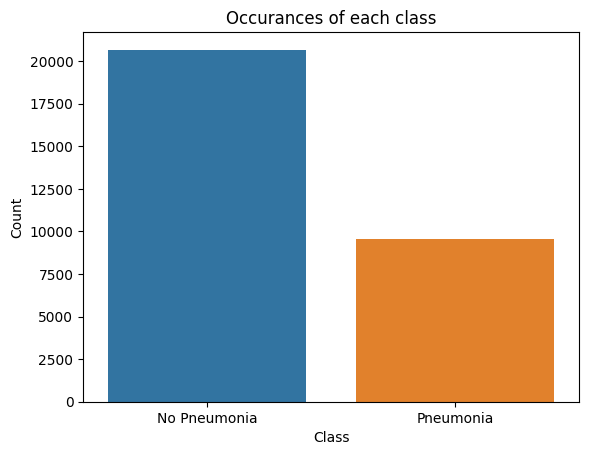

In [10]:
sns.barplot(x=['No Pneumonia', 'Pneumonia'],y=df['Target'].value_counts())
plt.title('Occurances of each class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

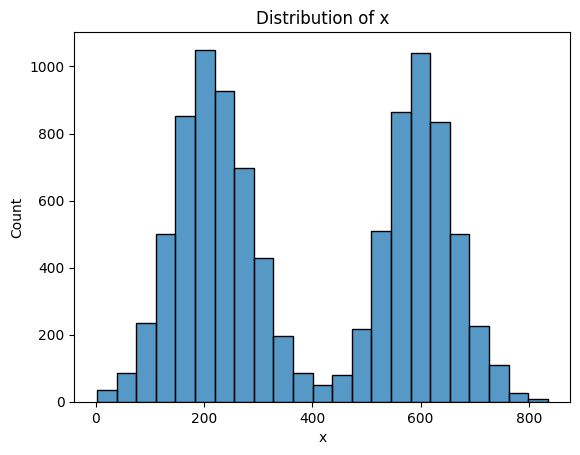

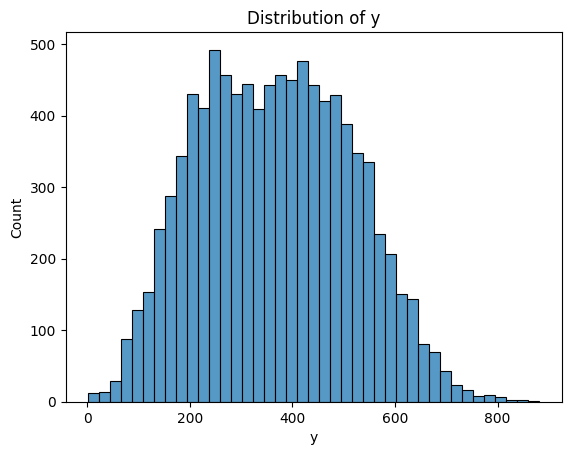

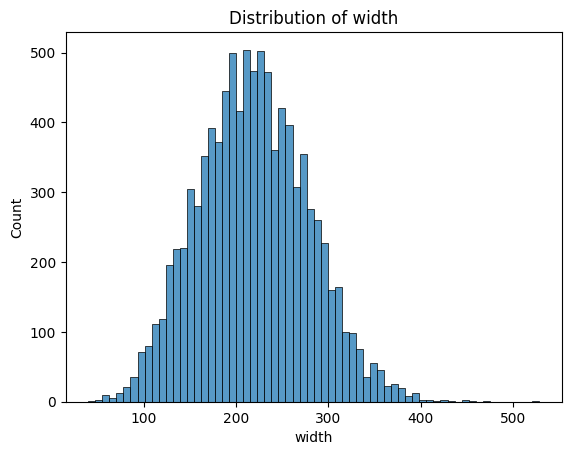

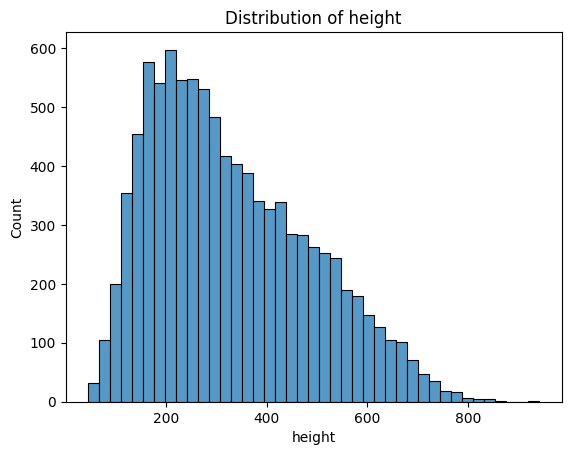

In [11]:
for col in df.columns[1:-1]:
    sns.histplot(df[col])
    plt.xlabel(str(col))
    plt.title('Distribution of '+str(col))
    plt.show()

## Creating Dataset According to YOLOv8 Format

In [12]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Target'])
X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=42, stratify=X_test['Target'])

In [13]:
def get_annotations(row):
    x,y,w,h,l = row
    if l==0:
        return None
    
    #Get center coordinates
    x_centre = x + w/2
    y_centre = y + h/2
    
    #Normalize data
    x_centre /= IMG_SIZE
    y_centre /= IMG_SIZE
    w /= IMG_SIZE
    h /= IMG_SIZE
    
    return f"0 {x_centre} {y_centre} {w} {h}\n"

def get_bbox(label):
    _,nx,ny,nw,nh = list(map(float,label.strip().split()))
    x = (nx - nw/2)*IMG_SIZE
    y = (ny - nh/2)*IMG_SIZE
    w = nw*IMG_SIZE
    h = nh*IMG_SIZE
    return x, y, w, h

In [17]:
def create_dataset(root_path, img_path ,df, mode='train'):
    #Make folder to store image and labels
    yolo_img_path = os.path.join(root_path , 'images')
    yolo_label_path = os.path.join(root_path , 'labels')
    train_img_path = os.path.join(yolo_img_path , mode)
    train_label_path = os.path.join(yolo_label_path , mode)
    
    if not os.path.exists(yolo_img_path):
        os.makedirs(yolo_img_path)
        os.makedirs(yolo_label_path)
    if not os.path.exists(train_img_path):
        os.makedirs(train_img_path)
        os.makedirs(train_label_path)
    assert (os.path.exists(train_img_path) and os.path.exists(train_label_path))==True
    
    for row in tqdm(range(len(df))):
        patient_id = df.iloc[row,0]
        #Save Image to img folder
        if not os.path.exists(os.path.join(train_img_path , patient_id+'.jpg')):
            dcm_path = os.path.join(img_path , patient_id+'.dcm')
            initial_img = pydicom.dcmread(dcm_path)
            img_pixels = initial_img.pixel_array
            final_path = os.path.join(train_img_path , patient_id+'.jpg')
            image = Image.fromarray(img_pixels)
            image.save(final_path)
            
        if mode=='test':
            continue
            
        #Save label to label folder (if exists)
        label = get_annotations(df.iloc[row,1:])
        if label is None:
            continue
        final_label_path = os.path.join(train_label_path , patient_id+'.txt')
        f = open(final_label_path, "a")
        f.write(label)
        f.close()
    
    return train_img_path, train_label_path

In [18]:
TRAIN_IMG_PATH, TRAIN_LABEL_PATH = create_dataset(DATASET_PATH,RSNA_IMAGES,X_train,'train')
VAL_IMG_PATH, VAL_LABEL_PATH = create_dataset(DATASET_PATH,RSNA_IMAGES,X_val,'val')
TEST_IMG_PATH, TEST_LABEL_PATH = create_dataset(DATASET_PATH,RSNA_IMAGES,X_test,'test')

100%|██████████| 3023/3023 [00:47<00:00, 63.52it/s]


In [ ]:
%%writefile config.yaml

path: '/kaggle/working/datasets' # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')
test: images/test
    
#Classes
names:
  0: pneumonia

In [ ]:
model = YOLO('yolov9c.pt')

In [ ]:
wandb.login(key='eb6cd00230a166a6f6eaed6cfdc43c439a932455')
# results = model.train(data='config.yaml', epochs=33)

In [ ]:
wandb.init(project="yolov9-finetuning", entity="mukulmisra19", 
           name="run 1",
           config={"epochs":30})  

# Checkpoint saving and uploading within the training loop
results = model.train(data='config.yaml', epochs=30, save_period=5, save_dir="checkpoints")  

In [ ]:
model.save("final_yolov9.pt")
# wandb.save("final_yolov9.pt")